# Compare the performance of the model trained on augmented data (basic) and raw data : PAMAP2

2024.10.09. ~ 2024.10.16.<br>
Gyuyeon Lim (lky473736) 

<br>

- **Reference**
    - https://github.com/uchidalab/time_series_augmentation/blob/master/utils/augmentation.py
    - https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.ipynb
    - https://pypi.org/project/transform3d/
    - http://dmqm.korea.ac.kr/activity/seminar/390
    - https://hyeongyuu.github.io/machine%20learning/Augmentation_timeseries/
    
<br>

### Abstract 

This study evaluates the impact of data augmentation techniques on the performance of machine learning models trained on the PAMAP2 dataset. Specifically, we compare models trained on raw data and those trained on data enhanced through basic augmentation methods such as **Jitter**, **Scaling**, **Permutation**, **Magnitude Warp**, **Time Warp**, **Random Guided Warp**, **Window Slice**, and **Window Warp**. These augmentation techniques aim to address class imbalance and enhance model robustness by generating diverse patterns from the original time-series data. The objective is to assess whether these transformations can improve model accuracy and generalization, ultimately providing insights into the efficacy of data augmentation for time-series classification tasks.


- **Data**
    - PAMAP2 dataset : https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring
    - data abstract : The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction and classification.

    - window size : 100 (will use way of sliding window)

- **Model**
    - CNN-LSTM
    - U-net
    - transformer-encoder

- **Way of Augmentation**
    - **Jitter**: Adds noise to the input data to generate augmented data.
    - **Scaling**: Scales the input data by a random factor to create augmented data.
    - **Permutation**: Shuffles the input data within specific segments to generate new patterns.
    - **Magnitude Warp**: Smoothly distorts certain points of the input data to generate augmented data.
    - **Time Warp**: Warps the time axis to create new data.
    - **Random Guided Warp**: Uses DTW or ShapeDTW to select a random pattern within the same class and applies warping.
    - **Window Slice**: Randomly selects a segment of the data and reduces it.
    - **Window Warp**: Stretches or compresses specific segments to create new patterns.
    
---

### Environment and importing libraries


In [1]:
import psutil
import platform
import GPUtil

# System and CPU information
system = platform.system()
processor = platform.processor()

cpu_count = psutil.cpu_count(logical=True)
cpu_usage = psutil.cpu_percent(interval=1)
virtual_memory = psutil.virtual_memory()

print(f"System: {system}")
print(f"Processor: {processor}")
print(f"CPU Cores: {cpu_count}")
print(f"CPU Usage: {cpu_usage}%")
print(f"Total RAM: {virtual_memory.total / (1024**3):.2f} GB")
print(f"Available RAM: {virtual_memory.available / (1024**3):.2f} GB")
print(f"RAM Usage: {virtual_memory.percent}%")

# GPU information
gpus = GPUtil.getGPUs()
if gpus:
    for gpu in gpus:
        print(f"\nGPU {gpu.id}: {gpu.name}")
        print(f"  Load: {gpu.load * 100:.1f}%")
        print(f"  Free Memory: {gpu.memoryFree / 1024:.2f} GB")
        print(f"  Used Memory: {gpu.memoryUsed / 1024:.2f} GB")
        print(f"  Total Memory: {gpu.memoryTotal / 1024:.2f} GB")
        print(f"  Temperature: {gpu.temperature} °C")
else:
    print("\nNo GPU found.")


System: Linux
Processor: x86_64
CPU Cores: 12
CPU Usage: 2.0%
Total RAM: 1039.13 GB
Available RAM: 1016.33 GB
RAM Usage: 2.2%

GPU 0: CUDA GPU
  Load: nan%
  Free Memory: 23.95 GB
  Used Memory: 0.05 GB
  Total Memory: 24.00 GB
  Temperature: 28.0 °C

GPU 1: CUDA GPU
  Load: nan%
  Free Memory: 23.95 GB
  Used Memory: 0.05 GB
  Total Memory: 24.00 GB
  Temperature: 28.0 °C


In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-12 15:19:12.849505: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


In [4]:
# ignoring future warnings
import warnings
warnings.simplefilter('ignore')

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

-----

### data load, preprocessing


In [6]:
# column names of the data

columns = ['time_stamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_3D_acceleration_16_x',  'hand_3D_acceleration_16_y',
         'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x', 'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z', 'hand_3D_gyroscope_x',
         'hand_3D_gyroscope_y',  'hand_3D_gyroscope_z', 'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y', 'hand_3D_magnetometer_z',
         'hand_4D_orientation_x', 'hand_4D_orientation_y', 'hand_4D_orientation_z', 'hand_4D_orientation_w', 'chest_temperature', 'chest_3D_acceleration_16_x',
         'chest_3D_acceleration_16_y', 'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x', 'chest_3D_acceleration_6_y',  'chest_3D_acceleration_6_z',
         'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z', 'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
         'chest_3D_magnetometer_z', 'chest_4D_orientation_x', 'chest_4D_orientation_y', 'chest_4D_orientation_z', 'chest_4D_orientation_w',
         'ankle_temperature', 'ankle_3D_acceleration_16_x', 'ankle_3D_acceleration_16_y', 'ankle_3D_acceleration_16_z', 'ankle_3D_acceleration_6_x',
         'ankle_3D_acceleration_6_y', 'ankle_3D_acceleration_6_z', 'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z',
         'ankle_3D_magnetometer_x', 'ankle_3D_magnetometer_y', 'ankle_3D_magnetometer_z', 'ankle_4D_orientation_x', 'ankle_4D_orientation_y',
         'ankle_4D_orientation_z', 'ankle_4D_orientation_w']

In [7]:
# data load

def load_data() :
    root = os.path.join('..', '..', '..', 'data', 'PAMAP', 'PAMAP')
    data_list = []  
    
    for i in range(101, 110) : 
        path = os.path.join(root, f"{i}.dat")
        df = pd.read_table(path, header=None, sep='\s+')
        
        print (f"{i}.dat is {df.shape}")
        
        df.columns = columns
        df['id'] = i
        
        print (f"{len(df['activity_id'].unique())}")
        
        data_list.append(df)  

    #  data = pd.concat(data_list, ignore_index=True)
    # data.reset_index(drop=True, inplace=True)
    
    return data_list

df_list = load_data()

101.dat is (376417, 54)
13
102.dat is (447000, 54)
13
103.dat is (252833, 54)
9
104.dat is (329576, 54)
12
105.dat is (374783, 54)
13
106.dat is (361817, 54)
13
107.dat is (313599, 54)
12
108.dat is (408031, 54)
13
109.dat is (8477, 54)
2


In [8]:
# concatenation the dataframe

df = pd.concat(df_list, ignore_index=True)
df.reset_index(drop=True, inplace=True)

df

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,109


In [9]:
# A function that checks the percentage of missing values,unique values,percentage of one catagory values and type against each column.

'''
    Unique_values : the component that not null
    Missing values : null
    Peercentage of Missing values : number of null / number of all samples
    Data Type : dtype of each cols
'''

def statistics(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum(), df[col].isnull().sum() * 100 / df.shape[0], df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Missing values', 'Percentage of Missing Values', 'Data Type'])
    stats_df.set_index('Feature', drop=True, inplace=True)
    stats_df.drop(stats_df[stats_df['Missing values'] == 0].index, axis=0, inplace=True)
    stats_df.sort_values('Percentage of Missing Values', ascending=False, inplace=True)
    return stats_df

statistics(df).T

Feature,heart_rate,hand_3D_gyroscope_z,hand_temperature,hand_4D_orientation_z,hand_4D_orientation_y,hand_4D_orientation_x,hand_3D_magnetometer_z,hand_3D_magnetometer_y,hand_3D_magnetometer_x,hand_4D_orientation_w,...,chest_3D_acceleration_6_y,chest_3D_gyroscope_x,chest_4D_orientation_z,chest_3D_gyroscope_z,chest_3D_magnetometer_x,chest_3D_magnetometer_y,chest_3D_magnetometer_z,chest_4D_orientation_x,chest_4D_orientation_y,chest_3D_gyroscope_y
Unique_values,146,1875844,138,1247500,1347718,1002405,1130762,1220419,1156337,1400053,...,763044,1827061,1449428,1802080,1410128,626338,1270492,849688,951475,1918959
Missing values,2610265,13141,13141,13141,13141,13141,13141,13141,13141,13141,...,3563,3563,3563,3563,3563,3563,3563,3563,3563,3563
Percentage of Missing Values,90.8698,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,...,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037
Data Type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [10]:
# Function that fills the null values with either the mean or median based on a normal test

def fillnull(columns, df=df):
    from scipy.stats import normaltest
    # Iterating Numerical columns
    for i in columns:
        # Finding Normality of feature
        st, p = normaltest(df[i].dropna())

        # Checking if normal or not
        if p > 0.05:
            # Filling with mean if normal
            df[i].fillna(df[i].mean(), inplace=True)
        else:
            # Filling with median if not normal
            df[i].fillna(df[i].median(), inplace=True)
            
# Taking out column names that have null values
num_cols = statistics(df).index

# Applying function
fillnull(num_cols)

In [11]:
# Acitvity_id = 0 is not an valid activity so it should be dropped
df.drop(df[df['activity_id']==0].index, inplace=True, axis=0)

In [12]:
# As it can be seen here there is no null values any longer in the dataframe.
print (df.isnull().sum())
print (~any(df.isnull()))

time_stamp                    0
activity_id                   0
heart_rate                    0
hand_temperature              0
hand_3D_acceleration_16_x     0
hand_3D_acceleration_16_y     0
hand_3D_acceleration_16_z     0
hand_3D_acceleration_6_x      0
hand_3D_acceleration_6_y      0
hand_3D_acceleration_6_z      0
hand_3D_gyroscope_x           0
hand_3D_gyroscope_y           0
hand_3D_gyroscope_z           0
hand_3D_magnetometer_x        0
hand_3D_magnetometer_y        0
hand_3D_magnetometer_z        0
hand_4D_orientation_x         0
hand_4D_orientation_y         0
hand_4D_orientation_z         0
hand_4D_orientation_w         0
chest_temperature             0
chest_3D_acceleration_16_x    0
chest_3D_acceleration_16_y    0
chest_3D_acceleration_16_z    0
chest_3D_acceleration_6_x     0
chest_3D_acceleration_6_y     0
chest_3D_acceleration_6_z     0
chest_3D_gyroscope_x          0
chest_3D_gyroscope_y          0
chest_3D_gyroscope_z          0
chest_3D_magnetometer_x       0
chest_3D

In [13]:
# information of dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942872 entries, 2928 to 2872019
Data columns (total 55 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   time_stamp                  float64
 1   activity_id                 int64  
 2   heart_rate                  float64
 3   hand_temperature            float64
 4   hand_3D_acceleration_16_x   float64
 5   hand_3D_acceleration_16_y   float64
 6   hand_3D_acceleration_16_z   float64
 7   hand_3D_acceleration_6_x    float64
 8   hand_3D_acceleration_6_y    float64
 9   hand_3D_acceleration_6_z    float64
 10  hand_3D_gyroscope_x         float64
 11  hand_3D_gyroscope_y         float64
 12  hand_3D_gyroscope_z         float64
 13  hand_3D_magnetometer_x      float64
 14  hand_3D_magnetometer_y      float64
 15  hand_3D_magnetometer_z      float64
 16  hand_4D_orientation_x       float64
 17  hand_4D_orientation_y       float64
 18  hand_4D_orientation_z       float64
 19  hand_4D_orientatio

In [14]:
# delete cols that doesn't need

df = df.drop (['time_stamp', 'id'], axis=1)
df.columns

Index(['activity_id', 'heart_rate', 'hand_temperature',
       'hand_3D_acceleration_16_x', 'hand_3D_acceleration_16_y',
       'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x',
       'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z',
       'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y', 'hand_3D_gyroscope_z',
       'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y',
       'hand_3D_magnetometer_z', 'hand_4D_orientation_x',
       'hand_4D_orientation_y', 'hand_4D_orientation_z',
       'hand_4D_orientation_w', 'chest_temperature',
       'chest_3D_acceleration_16_x', 'chest_3D_acceleration_16_y',
       'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x',
       'chest_3D_acceleration_6_y', 'chest_3D_acceleration_6_z',
       'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z',
       'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
       'chest_3D_magnetometer_z', 'chest_4D_orientation_x',
       'chest_4D_orientation_y', 'chest_4D_orientat

In [15]:
import pandas as pd

def correlation_matrix(df):
    corr = df.corr()

    sorted_corr = corr['activity_id'].abs().sort_values(ascending=False)

    return sorted_corr

sorted_correlations = correlation_matrix(df)

print(sorted_correlations)

activity_id                   1.000000
chest_3D_acceleration_6_z     0.429279
chest_3D_acceleration_16_z    0.428210
ankle_4D_orientation_w        0.337902
chest_4D_orientation_x        0.324685
chest_3D_magnetometer_y       0.298333
chest_3D_magnetometer_z       0.265201
chest_3D_magnetometer_x       0.241262
ankle_3D_magnetometer_z       0.209349
hand_4D_orientation_x         0.207247
ankle_3D_magnetometer_x       0.199028
ankle_temperature             0.196692
hand_3D_magnetometer_y        0.188350
ankle_4D_orientation_y        0.187077
chest_temperature             0.160191
hand_temperature              0.159274
chest_3D_acceleration_16_x    0.149992
chest_3D_acceleration_6_x     0.147551
ankle_3D_acceleration_6_x     0.145586
ankle_3D_acceleration_16_x    0.134114
hand_3D_acceleration_16_x     0.131847
hand_3D_acceleration_6_x      0.131142
hand_3D_acceleration_6_z      0.118543
hand_3D_acceleration_16_z     0.116912
chest_3D_acceleration_16_y    0.105699
hand_4D_orientation_z    

In [16]:
# '''
#     To reduce the complexity of the model due to too many features, 
#     only features related to 'ankle' and 'heart rate' will be retained.
# '''

# col_activity_id = df['activity_id']
# col_heart_rate = df['heart_rate']

# df = df.filter(like='ankle', axis=1)

# df['heart_rate'] = col_heart_rate
# df['activity_id'] = col_activity_id

In [17]:
# see that target is 0-based

print (df['activity_id'].unique())


'''
    we need to encoding now to 0-based
    (labelencoding)
'''

[ 1  2  3 17 16 12 13  4  7  6  5 24]


'\n    we need to encoding now to 0-based\n    (labelencoding)\n'

In [18]:
# label encoding

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['activity_id'] = encoder.fit_transform(df['activity_id'])

print (df['activity_id'].unique())

[ 0  1  2 10  9  7  8  3  6  5  4 11]


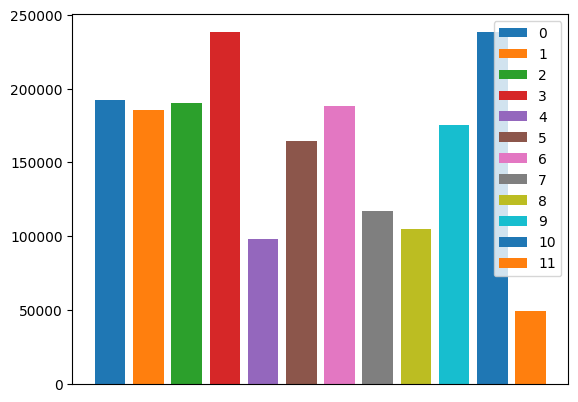

3     238761
10    238690
0     192523
2     189931
6     188107
1     185188
9     175353
5     164600
7     117216
8     104944
4      98199
11     49360
Name: activity_id, dtype: int64


"\n    This situation solved using SMOTE and oversampling random position at records before bunches of documents.\n    But this data is time-series, has depandancy of time.\n    \n    so i will do the original augmentation that Terry Taewoong Um offered. \n    That file will be uploaded at './augmentation'\n"

In [19]:
# activity_id - countplot, value_count

import math

target = np.unique(df['activity_id'])

width = 1
for compo in target : 
    plt.bar(width, len(df[df['activity_id'] == compo]), 
            label=compo)
    width += 1
    
plt.xticks([], [])

plt.legend()
plt.show()

print (df['activity_id'].value_counts())

'''
    This situation solved using SMOTE and oversampling random position at records before bunches of documents.
    But this data is time-series, has depandancy of time.
    
    so i will do the original augmentation that Terry Taewoong Um offered. 
    That file will be uploaded at './augmentation'
'''

In [20]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

X = df[[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y = df['activity_id']

SS = StandardScaler()
X = SS.fit_transform(X)

df = pd.DataFrame(data=X, 
                        columns = [feature_name for feature_name in df.columns if feature_name != 'activity_id'])
df['activity_id'] = y.values

df

,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,activity_id
0,0.005952,-1.334385,1.152065,0.684157,0.501860,1.145243,0.758982,0.503435,-0.004045,-0.002237,...,0.013996,-0.002954,-1.612155,-1.768779,-3.842566,2.042947,0.015937,-0.910038,0.118979,0
1,0.005952,-1.334385,1.164402,0.595884,0.541651,1.149559,0.696864,0.507490,-0.130084,-0.014954,...,0.059008,-0.000834,-1.600335,-1.743646,-3.842363,2.042947,0.015937,-0.910038,0.118979,0
2,0.005952,-1.334385,1.164231,0.518647,0.561593,1.148904,0.623282,0.507762,-0.180309,-0.029947,...,-0.024811,-0.006259,-1.570259,-1.718901,-3.854879,2.042947,0.015937,-0.910038,0.118979,0
3,0.005952,-1.334385,1.152499,0.518829,0.580807,1.141205,0.561259,0.531023,-0.146090,-0.021707,...,0.027928,0.009598,-1.593402,-1.779832,-3.817681,2.042947,0.015937,-0.910038,0.118979,0
4,-0.975223,-1.334385,1.165866,0.535561,0.629752,1.138862,0.558986,0.550221,-0.053273,-0.060994,...,-0.019245,-0.006979,-1.562796,-1.780742,-3.817925,2.042947,0.015937,-0.910038,0.118979,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942867,0.005952,-4.272171,1.599367,0.355052,0.504588,1.573084,0.378911,0.481109,-0.218753,-0.157520,...,0.037286,-0.000899,-0.775617,-0.103795,-0.885062,0.468808,-0.495552,1.215173,-0.671289,11
1942868,0.005952,-4.272171,1.604674,0.338291,0.475574,1.570355,0.362815,0.450473,-0.208369,-0.176635,...,0.063224,-0.005936,-0.789134,-0.103127,-0.849070,0.468646,-0.495696,1.215502,-0.670876,11
1942869,0.005952,-4.272171,1.610541,0.310629,0.475875,1.584650,0.351205,0.423632,-0.219296,-0.174733,...,0.002276,-0.004977,-0.760794,-0.122171,-0.848952,0.467805,-0.496194,1.216303,-0.670112,11
1942870,6.628887,-4.272171,1.622619,0.299496,0.476224,1.584183,0.323589,0.381524,-0.177422,-0.148392,...,0.000263,-0.007352,-0.782375,-0.091495,-0.841855,0.467511,-0.496153,1.217100,-0.669379,11


In [21]:
# input, target split

input_PAMAP = df.drop('activity_id', axis=1)
target_PAMAP = df['activity_id']

input_PAMAP.shape, target_PAMAP.shape

((1942872, 52), (1942872,))

------

### sliding window : split_sequences_freq()

<img src="https://velog.velcdn.com/images/wlwl99/post/e0ebddc2-e075-41e5-bec6-ac424364d1da/image.png" width=400px>

The function above is designed using the **sliding window technique**, but this time the target is determined by **frequency** rather than the last value. Sliding window is a common approach used in two-pointer algorithms, where elements are selected by sliding across the dataset, as illustrated in the earlier figure.

In this function, **`len(sequences)` represents the number of records (rows) in the DataFrame**. The loop iterates through each row, with `i` representing the current row index. `end_ix` is calculated by adding `n_steps` to the current row index, where `n_steps` is the size of the window. Here, the **window slides over the data, selecting a block of rows**.

The loop terminates if `end_ix` exceeds the total number of rows in the DataFrame. Inside the loop, `seq_x` is the input data that selects the rows between the `i`-th and `end_ix - 1`-th row, excluding the last column (target column). `seq_y` is the corresponding target data, which includes the values in the last column for those rows.

Instead of using the last target value as in the previous approach, **the most frequent target class within the window** is selected as the target. This is done using the `Counter` from the `collections` module, which finds the most common class in `seq_y`. Finally, the input data (`X`) and the most frequent class (`y`) are stored for each window.

In [22]:
# sliding window (judging by frequency)

from collections import Counter

def split_sequences_freq(sequences, n_steps, hop=1):
    X, y = list(), list()
    
    # Check if sequences is a DataFrame, convert if necessary
    if not isinstance(sequences, pd.DataFrame):
        sequences = pd.DataFrame(sequences)

    i = 0
    while (i < len(sequences)) : 
        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x = sequences.iloc[i:end_ix, :-1].values
        seq_y = sequences.iloc[i:end_ix, -1].values   
        
        # Find the most frequent class in seq_y
        most_frequent_class = Counter(seq_y).most_common(1)[0][0]
        
        X.append(seq_x)
        y.append(int(most_frequent_class))
        
        i += hop

    return np.array(X), np.array(y)

------

### Modeling

In [23]:
# CNN-LSTM

from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_CNN_LSTM(input_shape, target_size, l2_lambda=0.01):
    model = keras.Sequential()

    model.add(layers.Conv1D(64, kernel_size=3, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Conv1D(32, kernel_size=2, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.4))

    model.add(layers.LSTM(16, return_sequences=False))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

    model.add(layers.Dense(target_size, activation='softmax'))

    return model


In [24]:
# U-Net

from tensorflow.keras import layers, models

def build_unet_1d_custom(input_shape, num_classes, l2_lambda=0.01):

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(inputs)
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c1)
    p1 = layers.MaxPooling1D(pool_size=2)(c1)  # Downsampling

    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p1)
    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c2)
    p2 = layers.MaxPooling1D(pool_size=2)(c2)  # Downsampling

    # Bottleneck
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p2)
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(b1)

    # Decoder
    u2 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(b1)  # Upsampling

    # Ensure shapes match for concatenation
    c2_shape = layers.Lambda(lambda x: x[:, :u2.shape[1], :])(c2)  # Adjust shape of c2 to match u2
    u2 = layers.concatenate([u2, c2_shape], axis=-1)  # Concatenate

    c3 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(u2)
    c3 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c3)

    u3 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(c3)  # Upsampling
    c1_shape = layers.Lambda(lambda x: x[:, :u3.shape[1], :])(c1)  # Adjust shape of c1 to match u3
    u3 = layers.concatenate([u3, c1_shape], axis=-1)  # Concatenate

    c4 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(u3)
    c4 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c4)

    # Output layer
    f1 = layers.Flatten()(c4)
    outputs = layers.Dense(num_classes, activation='softmax')(f1)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [25]:
# transformer-encoder

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, l2_lambda=0.01):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu",
                           kernel_regularizer=regularizers.l2(l2_lambda))(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1,
                           kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes=0,
    l2_lambda=0.01
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu",
                              kernel_regularizer=regularizers.l2(l2_lambda))(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(n_classes, activation="softmax")(x) # label
    return keras.Model(inputs, outputs)

In [26]:
# build pipeline to fit

from memory_profiler import profile

@profile  # to protect memory overflow
def run_all_model (X, y, models) :
    histories = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
    trained_models = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
#     early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    for idx, model in enumerate(models) : 
        print (f"model {idx} running")    
        try:
            history = model.fit(X, y, epochs=50, 
                                validation_split=0.2,
                                batch_size=512,
#                                 callbacks=[early_stopping_cb], 
                                verbose=True)
            
            if idx == 0: 
                histories['CNN_LSTM'] = history
                print ("CNN_LSTM completed")
                trained_models['CNN_LSTM'] = model
            elif idx == 1: 
                histories['UNet'] = history
                print ("UNet completed")
                trained_models['UNet'] = model
            else: 
                histories['transformer_encoder'] = history
                print ("transformer_encoder completed")
                trained_models['transformer_encoder'] = model
                
        except Exception as e: 
            print (f"Error occurred while running model {idx}: {e}")
    
    return histories, trained_models

def activate_all_model (X, y, input_shape, n_classes) :
    CNN_LSTM = build_CNN_LSTM(input_shape=input_shape,
                             target_size=n_classes)
    UNet = build_unet_1d_custom(input_shape=input_shape,
                               num_classes=n_classes)
    transformer_encoder = build_transformer(
                                input_shape=input_shape,
                                head_size=128,
                                num_heads=4,
                                ff_dim=4,
                                num_transformer_blocks=4,
                                mlp_units=[256],
                                mlp_dropout=0.4,
                                dropout=0.25,
                                n_classes=n_classes
                            )
    
    CNN_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                     loss='sparse_categorical_crossentropy')
    UNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                 loss='sparse_categorical_crossentropy')
    transformer_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'], 
                                loss='sparse_categorical_crossentropy')
    
    models = [CNN_LSTM, UNet, transformer_encoder]
    
    histories, trained_models = run_all_model(X, y, models)
    return histories, trained_models

------

### original dataframe (no augmentation)

In [27]:
# no augmentation. train set, test set split

print (df.shape)

idx = int(df.shape[0]*0.8)

X_train = df.iloc[:idx][[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y_train = df.iloc[:idx]['activity_id']
X_test = df.iloc[idx:][[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y_test = df.iloc[idx:]['activity_id']

X_train.shape, X_test.shape

(1942872, 53)


((1554297, 52), (388575, 52))

In [28]:
# no augmentation. so just use split_sequence_freq

train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

X_train_seq, y_train_seq = split_sequences_freq(train_set, 100, 10) # tie 100 records, hop 10
print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences_freq(test_set, 100, 10) # tie 100 records, hop 10
print ("test : ", X_test_seq.shape, y_test_seq.shape)

print (len(set(y_train_seq)))
print (len(set(y_test_seq)))

train :  (155420, 100, 52) (155420,)
test :  (38848, 100, 52) (38848,)
12
12


In [29]:
# compile -> fit -> return histories

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
n_classes = 12
histories_original, trained_models = activate_all_model(X_train_seq, y_train_seq, input_shape, n_classes)

ERROR: Could not find file /tmp/ipykernel_9931/3517083628.py
model 0 running
Epoch 1/50
243/243 [==============================] - 16s 23ms/step - loss: 4.5011 - accuracy: 0.1732 - val_loss: 4.0400 - val_accuracy: 0.3627
Epoch 2/50
243/243 [==============================] - 3s 13ms/step - loss: 3.4884 - accuracy: 0.3741 - val_loss: 3.0614 - val_accuracy: 0.4102
Epoch 3/50
243/243 [==============================] - 3s 13ms/step - loss: 2.6891 - accuracy: 0.5021 - val_loss: 2.5234 - val_accuracy: 0.5631
Epoch 4/50
243/243 [==============================] - 3s 13ms/step - loss: 2.2303 - accuracy: 0.6111 - val_loss: 2.2343 - val_accuracy: 0.6349
Epoch 5/50
243/243 [==============================] - 3s 13ms/step - loss: 1.9214 - accuracy: 0.6828 - val_loss: 2.0139 - val_accuracy: 0.6670
Epoch 6/50
243/243 [==============================] - 3s 13ms/step - loss: 1.7119 - accuracy: 0.7131 - val_loss: 1.9157 - val_accuracy: 0.6566
Epoch 7/50
243/243 [==============================] - 3s 13ms/st

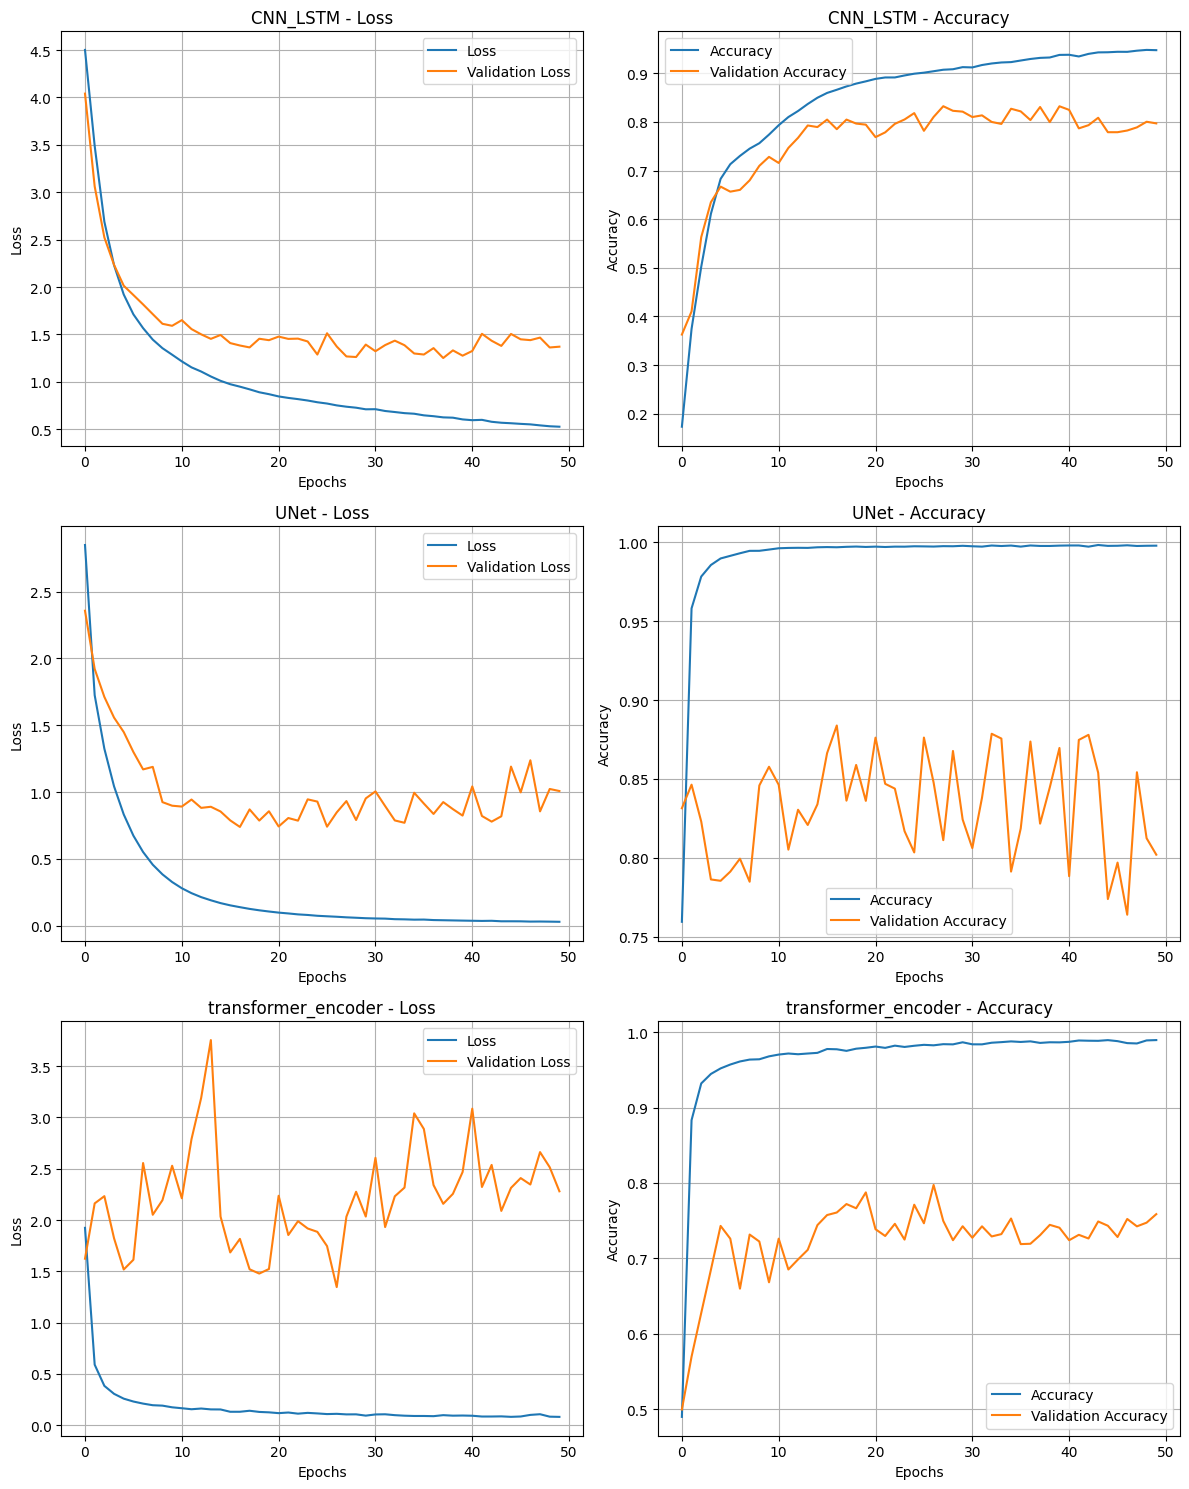

In [30]:
# loss, validation loss, acc, validation acc visualliztion

def draw_history(histories):
    num_models = len(histories)
    fig, ax = plt.subplots(num_models, 2, figsize=(12, 5 * num_models))

    for i, (model_name, history) in enumerate(histories.items()):
        ax[i, 0].plot(history.history['loss'], label='Loss')
        ax[i, 0].plot(history.history['val_loss'], label='Validation Loss')
        ax[i, 0].set_title(f'{model_name} - Loss')
        ax[i, 0].set_xlabel('Epochs')
        ax[i, 0].set_ylabel('Loss')
        ax[i, 0].legend()
        ax[i, 0].grid()

        ax[i, 1].plot(history.history['accuracy'], label='Accuracy')
        ax[i, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax[i, 1].set_title(f'{model_name} - Accuracy')
        ax[i, 1].set_xlabel('Epochs')
        ax[i, 1].set_ylabel('Accuracy')
        ax[i, 1].legend()
        ax[i, 1].grid()

    plt.tight_layout()
    plt.show()

draw_history(histories_original)

In [31]:
# evaulate

def extract_train_test_scores(models, X_train, y_train, X_test, y_test) :
    scores = {}
    for model_name, model in models.items():
        if model:
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score  = model.evaluate(X_test, y_test, verbose=0)
            scores[model_name] = {'train_score': train_score, 'test_score': test_score}
    return scores


evaluation_original = extract_train_test_scores(trained_models, X_train_seq, y_train_seq,
                                                X_test_seq, y_test_seq)
print (evaluation_original)

{'CNN_LSTM': {'train_score': [0.5838272571563721, 0.9510552287101746], 'test_score': [4.634674072265625, 0.4088241457939148]}, 'UNet': {'train_score': [0.22341978549957275, 0.9590400457382202], 'test_score': [5.586033821105957, 0.47237953543663025]}, 'transformer_encoder': {'train_score': [0.7371132373809814, 0.9156607985496521], 'test_score': [8.452863693237305, 0.5108628273010254]}}


In [33]:
# get accuracy, precision, recall, F1 score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def extract_performance_metrics(models, X_test, y_test) :
    metrics = {}
    for model_name, model in models.items():
        if model:
            y_pred = model.predict(X_test)
            y_pred_classes = y_pred.argmax(axis=1)
            accuracy  = accuracy_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes, average='weighted')
            recall    = recall_score(y_test, y_pred_classes, average='weighted')
            f1        = f1_score(y_test, y_pred_classes, average='weighted')
            metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}
    return metrics

performances_original = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_original)

1214/1214 [==============================] - 4s 3ms/step
{'CNN_LSTM': {'accuracy': 0.40882413509060955, 'precision': 0.5137284840441906, 'recall': 0.40882413509060955, 'f1_score': 0.3857132238396265}, 'UNet': {'accuracy': 0.4723795304777595, 'precision': 0.5444647194756926, 'recall': 0.4723795304777595, 'f1_score': 0.4577383919052419}, 'transformer_encoder': {'accuracy': 0.5108628500823723, 'precision': 0.5515762190813026, 'recall': 0.5108628500823723, 'f1_score': 0.49103884032298195}}


1214/1214 [==============================] - 3s 3ms/step
Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.52      0.95      0.67      2416
           1       0.11      0.01      0.02      2293
           2       0.03      0.04      0.03      2516
           3       0.65      0.74      0.69      6525
           4       0.45      0.05      0.09      2022
           5       0.77      0.53      0.63      4815
           6       0.48      0.45      0.47      5762
           7       0.48      0.11      0.18      2933
           8       0.12      0.46      0.19      2127
           9       0.52      0.50      0.51      2625
          10       1.00      0.01      0.01      3299
          11       0.26      0.53      0.35      1515

    accuracy                           0.41     38848
   macro avg       0.45      0.36      0.32     38848
weighted avg       0.51      0.41      0.39     38848



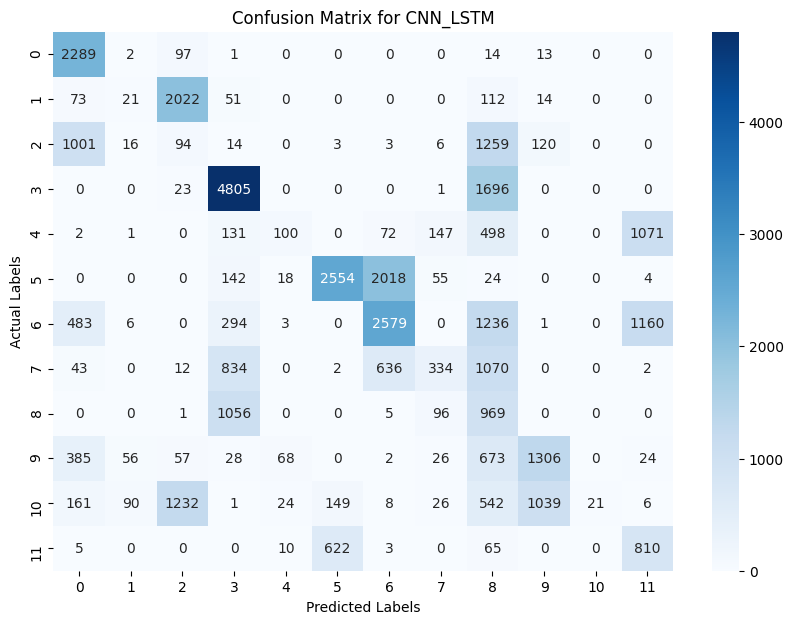

1214/1214 [==============================] - 2s 2ms/step
Classification Report for UNet:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2416
           1       0.87      0.52      0.65      2293
           2       0.10      0.05      0.07      2516
           3       0.76      0.94      0.84      6525
           4       0.93      0.04      0.08      2022
           5       1.00      0.73      0.84      4815
           6       0.52      0.47      0.50      5762
           7       0.47      0.43      0.45      2933
           8       0.08      0.43      0.14      2127
           9       0.39      0.75      0.52      2625
          10       0.20      0.00      0.00      3299
          11       0.68      0.27      0.39      1515

    accuracy                           0.47     38848
   macro avg       0.50      0.39      0.37     38848
weighted avg       0.54      0.47      0.46     38848



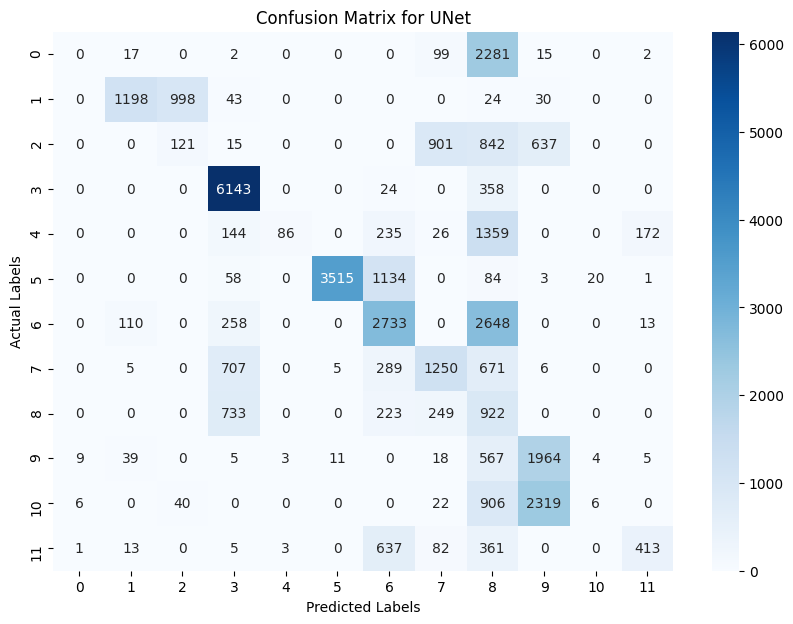

1214/1214 [==============================] - 4s 3ms/step
Classification Report for transformer_encoder:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2416
           1       0.00      0.00      0.00      2293
           2       0.03      0.01      0.02      2516
           3       0.74      0.58      0.65      6525
           4       0.79      0.17      0.28      2022
           5       0.88      0.97      0.92      4815
           6       0.90      0.46      0.61      5762
           7       0.31      0.70      0.43      2933
           8       0.18      0.60      0.28      2127
           9       0.35      0.73      0.48      2625
          10       0.05      0.01      0.02      3299
          11       0.49      0.51      0.50      1515

    accuracy                           0.51     38848
   macro avg       0.47      0.47      0.43     38848
weighted avg       0.55      0.51      0.49     38848



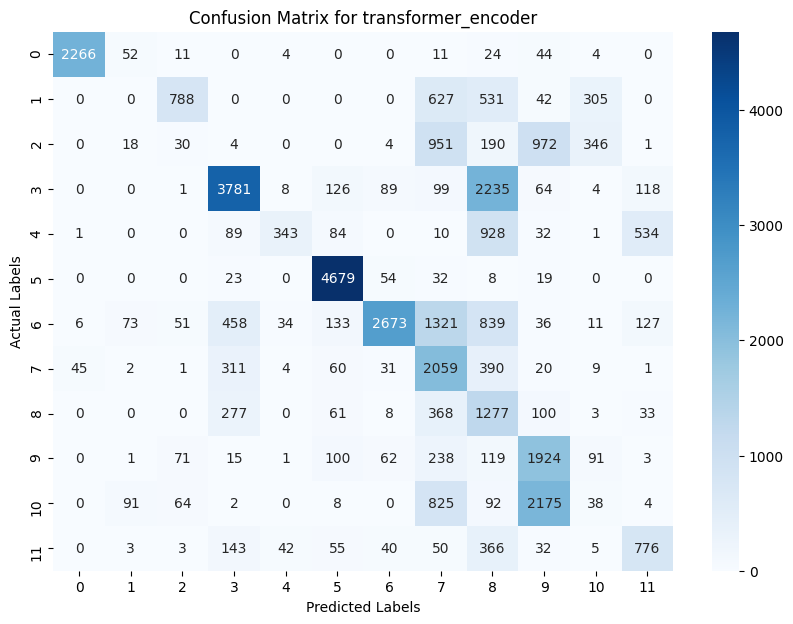

In [34]:
# draw confusion matrix, print the report

from sklearn.metrics import classification_report, confusion_matrix

def plot_classification_report_confusion_matrix(models, X_test, y_test) :
    for model_name, model in models.items():
        if model:
            y_pred = model.predict(X_test)
            y_pred_classes = y_pred.argmax(axis=1) 
            
            print(f"Classification Report for {model_name}:")
            print(classification_report(y_test, y_pred_classes))
            
            cm = confusion_matrix(y_test, y_pred_classes)
            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('Actual Labels')
            plt.xlabel('Predicted Labels')
            plt.show()
            
plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)